In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_csv('../dump/train_modified.csv')
test_df = pd.read_csv('../dump/test_modified.csv')
label = pd.read_csv('../input/test_label.csv')

In [3]:
target='acc_now_delinq'
IDcol = 'member_id'
print(train_df.shape, test_df.shape, label.shape)

(709903, 90) (177476, 89) (177476, 2)


In [ ]:
train_df.head().transpose()

In [4]:
def f2_score(preds, dtrain):  # preds是结果（概率值），dtrain是个带label的DMatrix
    beta = 2
    label = dtrain.get_label()  # 提取label

    # preds = 1.0 / (1.0 + np.exp(-preds))
    pred = [int(i >= 0.5) for i in preds]

    precision = metrics.precision_score(label,pred)
    recall = metrics.recall_score(label,pred)

    return 'f2_score', ((np.square(beta)+1)*precision * recall / (np.square(beta)*precision + recall))

In [6]:
# test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
#         watchlist = [(xgtrain,'train',(xgtest,'test'))]
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['acc_now_delinq'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
    print("Recall : %.4g" % metrics.recall_score(train_df['acc_now_delinq'].values, dtrain_predictions))
    print("Fbeta Score : %.4g" % metrics.fbeta_score(train_df['acc_now_delinq'].values, dtrain_predictions,beta=2))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df['acc_now_delinq'], dtrain_predprob))
    print(metrics.classification_report(train_df['acc_now_delinq'], dtrain_predictions))

    #     Predict on testing data:
    test_df['predprob'] = xgb1.predict_proba(test_df[predictors])[:,1]
    #     results = test_results.merge(dtest[['ID','predprob']], on='ID')
    #     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))

    feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    

[0]	train-auc:0.636705+0.0199598	test-auc:0.635028+0.0170661
[1]	train-auc:0.710974+0.0173932	test-auc:0.705947+0.0205489
[2]	train-auc:0.74693+0.0061692	test-auc:0.736415+0.0059903
[3]	train-auc:0.752041+0.00828007	test-auc:0.741761+0.00788384
[4]	train-auc:0.756947+0.00856786	test-auc:0.747642+0.0100917
[5]	train-auc:0.760215+0.00795447	test-auc:0.748254+0.008955
[6]	train-auc:0.76556+0.00477652	test-auc:0.752005+0.00746168
[7]	train-auc:0.77184+0.00327515	test-auc:0.759636+0.00578337
[8]	train-auc:0.774902+0.00205256	test-auc:0.761762+0.00789447
[9]	train-auc:0.77784+0.00252469	test-auc:0.763667+0.0088483
[10]	train-auc:0.779279+0.00263941	test-auc:0.765157+0.00754352
[11]	train-auc:0.782511+0.00281702	test-auc:0.767458+0.00759725
[12]	train-auc:0.784784+0.00316834	test-auc:0.769174+0.00670771
[13]	train-auc:0.789431+0.00387882	test-auc:0.77378+0.00473298
[14]	train-auc:0.790463+0.00510841	test-auc:0.77517+0.00414432
[15]	train-auc:0.792957+0.00372023	test-auc:0.776688+0.0032989
[16

[129]	train-auc:0.904347+0.00226774	test-auc:0.841756+0.00523045
[130]	train-auc:0.904732+0.0022968	test-auc:0.841758+0.00524767
[131]	train-auc:0.905056+0.00232932	test-auc:0.841797+0.00525851
[132]	train-auc:0.905376+0.00234277	test-auc:0.841845+0.0052645
[133]	train-auc:0.905743+0.00235123	test-auc:0.841952+0.0053555
[134]	train-auc:0.906206+0.00244157	test-auc:0.842003+0.00536813
[135]	train-auc:0.906568+0.00238491	test-auc:0.842042+0.00544067
[136]	train-auc:0.906891+0.00242414	test-auc:0.842081+0.00538988
[137]	train-auc:0.907281+0.00241726	test-auc:0.842141+0.00540169
[138]	train-auc:0.907695+0.00234221	test-auc:0.84213+0.00544715
[139]	train-auc:0.908114+0.00233014	test-auc:0.842203+0.00525307
[140]	train-auc:0.908616+0.0023684	test-auc:0.842325+0.00524432
[141]	train-auc:0.908989+0.00233868	test-auc:0.842382+0.00526139
[142]	train-auc:0.909389+0.00227563	test-auc:0.842424+0.00525699
[143]	train-auc:0.909888+0.00223717	test-auc:0.842526+0.00530853
[144]	train-auc:0.910168+0.002

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9954
Recall : 0.001215
Fbeta Score : 0.001518
AUC Score (Train): 0.918873
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    706610
        1.0       1.00      0.00      0.00      3293

avg / total       1.00      1.00      0.99    709903

Training Finsh


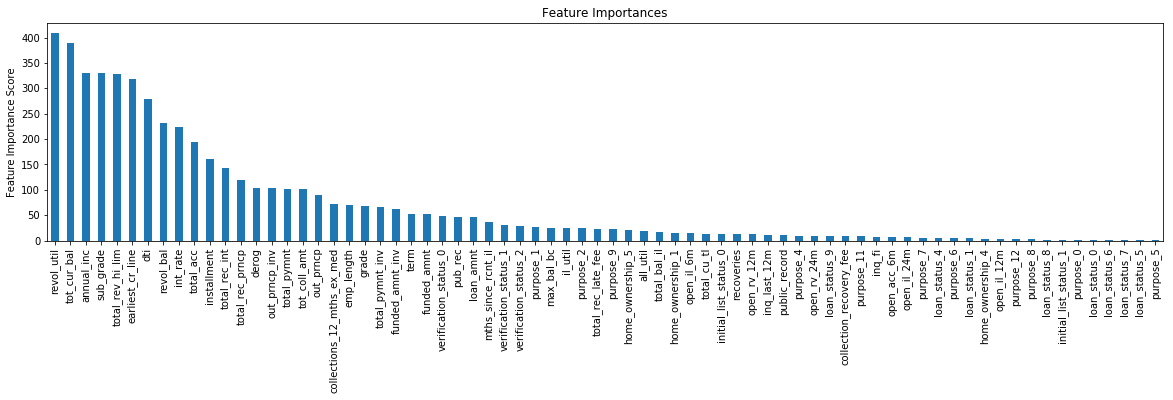

In [10]:
predictors = [x for x in train_df.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        n_jobs = -1,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_df, test_df, predictors)
print("Training Finsh")

In [11]:
#Predict training set:
dtrain_predictions = xgb1.predict(train_df[predictors])
dtrain_predprob = xgb1.predict_proba(train_df[predictors])[:,1]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9954
Recall : 0.001215
Fbeta Score : 0.001518
AUC Score (Train): 0.918873
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    706610
        1.0       1.00      0.00      0.00      3293

avg / total       1.00      1.00      0.99    709903

Fbeta Score : 0


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


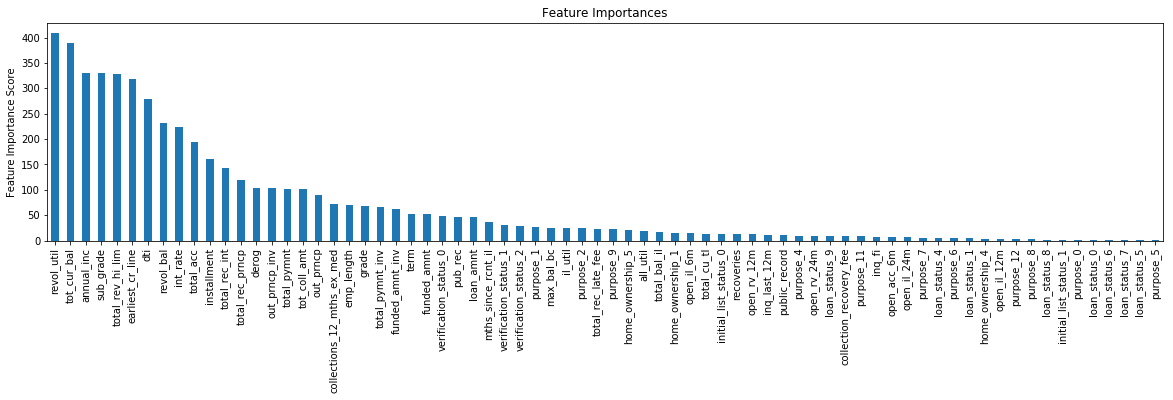

In [12]:
#Print model report:
dtest_predictions=xgb1.predict(test_df[predictors])
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("Recall : %.4g" % metrics.recall_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("Fbeta Score : %.4g" % metrics.fbeta_score(train_df['acc_now_delinq'].values, dtrain_predictions,beta=2))
print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df['acc_now_delinq'], dtrain_predprob))
print(metrics.classification_report(train_df['acc_now_delinq'], dtrain_predictions))
print("Fbeta Score : %.4g" % metrics.fbeta_score(label['acc_now_delinq'].values, dtest_predictions,beta=2))

#     Predict on testing data:
# test_df['predprob'] = xgb1.predict_proba(test_df[predictors])[:,1]

#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))

feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:

#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
print(dtest_predictions.shape, sub.shape)
for c in sub.columns[sub.columns != IDcol]:
    sub[c] = dtest_predictions

In [ ]:
sub.loc[sub['acc_now_delinq'] == 1]

In [37]:
print('Writing csv ...')
sub.to_csv('../submission/xgb_starter.csv', index=False)  # Thanks to @inversion


Writing csv ...
